In [29]:
import os
import math
import time
import datetime
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams ['font.sans-serif'] ='SimHei'               #显示中文
plt.rcParams ['axes.unicode_minus']=False               #显示负号
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score
 
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,Conv1D, MaxPooling1D,GlobalMaxPooling1D,Embedding,Dropout,Flatten,SimpleRNN,LSTM
from keras.callbacks import EarlyStopping
#from tensorflow.keras import regularizers
#from keras.utils.np_utils import to_categorical
from tensorflow.keras  import optimizers

In [39]:
data_path = '../data/A榜-训练集_海上风电预测_气象变量及实际功率数据.csv'
data0=pd.read_csv(data_path,encoding='gbk',nrows=int(57960),encoding_errors='ignore').iloc[:,2:].rename(columns={'出力(MW)':'y'})
data0.head()

,气压(Pa）,相对湿度（%）,云量,10米风速（10m/s）,10米风向（°),温度（K）,辐照强度（J/m2）,降水（m）,100m风速（100m/s）,100m风向（°),y
0,102249.6094,74.8513,0.007812,7.7041,26.5195,286.0695,0.0,0.000008,9.0820,27.5093,17.26
1,102252.0355,74.7530,0.000924,7.7710,23.5766,285.8647,0.0,0.000008,9.1374,24.7151,16.78
2,102248.5900,74.4995,0.003009,7.8272,21.5451,285.6935,0.0,0.000008,9.1856,22.7445,16.25
3,102240.4725,74.1432,0.011402,7.8637,20.2394,285.5512,0.0,0.000008,9.2158,21.4374,15.37
4,102228.8828,73.7366,0.023438,7.8781,19.4870,285.4330,0.0,0.000008,9.2237,20.6417,15.64


In [40]:
data0.fillna(0,inplace=True)
data0['y'] = data0['y'].replace('<NULL>', 0.0).astype(float)
data0['y'] = data0['y'].apply(lambda x:max(0.0,x))

In [41]:
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(12345)
    tf.random.set_seed(123)
    
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    r_2=r2_score(y_test, y_predict)
    score = 1 / (1+rmse)
    return mae, rmse, mape,r_2, score #mse

In [42]:

def build_sequences(text, window_size=24):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]
        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
 
def get_traintest(data,train_size=len(data0),window_size=24):
    train=data[:train_size]
    test=data[train_size-window_size:]
    X_train,y_train=build_sequences(train,window_size=window_size)
    X_test,y_test=build_sequences(test,window_size=window_size)
    return X_train,y_train[:,-1],X_test,y_test[:,-1]

In [43]:
def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    if mode=='RNN':
        #RNN
        model.add(SimpleRNN(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(SimpleRNN(hidden_dim[1]))     
        
    elif mode=='MLP':
        model.add(Dense(hidden_dim[0],activation='relu',input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(Flatten())
        model.add(Dense(hidden_dim[1],activation='relu'))
        
    elif mode=='LSTM':
        # LSTM
        model.add(LSTM(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(LSTM(hidden_dim[1]))
    elif mode=='GRU':
        #GRU
        model.add(GRU(hidden_dim[0],return_sequences=True, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        model.add(GRU(hidden_dim[1]))
    elif mode=='CNN':
        #一维卷积
        model.add(Conv1D(hidden_dim[0], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(X_train.shape[-2],X_train.shape[-1])))
        #model.add(MaxPooling1D())
        model.add(Conv1D(hidden_dim[1], kernel_size=3, padding='causal', strides=1, activation='relu', dilation_rate=2))
        #model.add(MaxPooling1D())
        model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model
 
def plot_loss(hist,imfname=''):
    plt.subplots(1,4,figsize=(16,2))
    for i,key in enumerate(hist.history.keys()):
        n=int(str('14')+str(i+1))
        plt.subplot(n)
        plt.plot(hist.history[key], 'k', label=f'Training {key}')
        plt.title(f'{imfname} Training {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.legend()
    plt.tight_layout()
    plt.show()
def plot_fit(y_test, y_pred):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"拟合值和真实值对比")
    plt.xlabel("Time")
    plt.ylabel('power')
    plt.legend()
    plt.show()

In [44]:

df_eval_all=pd.DataFrame(columns=['MAE','RMSE','MAPE','R2','SCORE'])
df_preds_all=pd.DataFrame()
def train_fuc(mode='LSTM',window_size=64,batch_size=32,epochs=50,hidden_dim=[32,16],train_ratio=0.8,show_loss=True,show_fit=True):
    #准备数据
    data=data0.to_numpy()
    #归一化
    scaler = MinMaxScaler() 
    scaler = scaler.fit(data[:,:-1])
    X=scaler.transform(data[:,:-1])   
 
    y_scaler = MinMaxScaler() 
    y_scaler = y_scaler.fit(data[:,-1].reshape(-1,1))
    y=y_scaler.transform(data[:,-1].reshape(-1,1))
    
    train_size=int(len(data)*train_ratio)
    X_train,y_train,X_test,y_test=get_traintest(np.c_[X,y],window_size=window_size,train_size=train_size)
    print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
    
    #构建模型
    s = time.time()
    set_my_seed()
    model=build_model(X_train=X_train,mode=mode,hidden_dim=hidden_dim)
    earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5)
    hist=model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,callbacks=[earlystop],verbose=0)
    if show_loss:
        plot_loss(hist)
            
    #预测
    y_pred = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred)
    y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
    #print(f'真实y的形状：{y_test.shape},预测y的形状：{y_pred.shape}')
    if show_fit:
        plot_fit(y_test, y_pred)
    e=time.time()
    print(f"运行时间为{round(e-s,3)}")
    df_preds_all[mode]=y_pred.reshape(-1,)
        
    s=list(evaluation(y_test, y_pred))
    df_eval_all.loc[f'{mode}',:]=s
    s=[round(i,3) for i in s]
    print(f'{mode}的预测效果为：MAE:{s[0]},RMSE:{s[1]},MAPE:{s[2]},R2:{s[3]},SCORE:{s[4]}')
    print("=======================================运行结束==========================================")

In [45]:
window_size=64
batch_size=32
epochs=50
hidden_dim=[32,16]
train_ratio=0.8
show_fit=True
show_loss=True

In [ ]:
mode='LSTM'  #RNN,GRU,CNN
train_fuc(mode='LSTM')

(46304, 64, 11) (46304,) (11592, 64, 11) (11592,)
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001FB134B6F70> (for post_execute):


(4572, 64, 11) (4572,) (1160, 64, 11) (1160,)


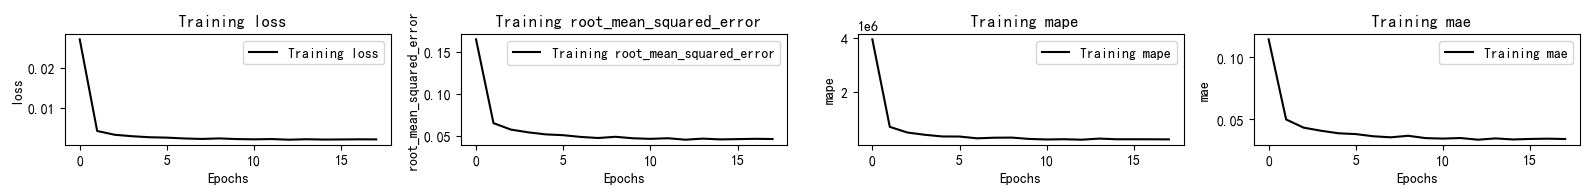

37/37 [==============================] - 3s 9ms/step


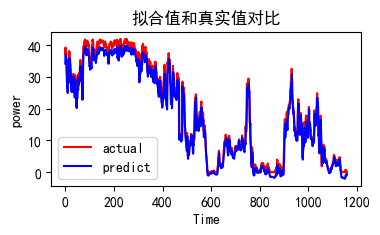

运行时间为98.436
GRU的预测效果为：MAE:1.679,RMSE:2.153,MAPE:inf,R2:0.979,SCORE:0.317
=======================================运行结束==========================================


C:\Users\Linzelun\AppData\Local\Temp\ipykernel_4904\2893380340.py:11: RuntimeWarning: divide by zero encountered in divide
  mape=(abs(y_predict -y_test)/ y_test).mean()


In [38]:
  #RNN,GRU,CNN
train_fuc(mode='GRU')